In [ ]:
import os
import numpy as np
import pandas as pd
from numpy.random import shuffle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

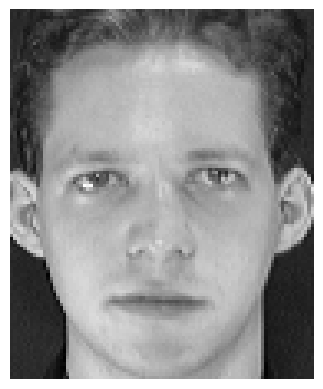

In [ ]:
import cv2
import matplotlib.pyplot as plt

def read_pgm(file_path):
    return cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

def show_image(image_data):
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')  # Hide axis labels
    plt.show()

file_path = f'/kaggle/input/att-images/ATT images/s1/1.pgm'
image_data = read_pgm(file_path)
show_image(image_data)

In [ ]:
image_data.shape

(112, 92)

In [ ]:
def get_data(path_data='/kaggle/input/att-images/ATT images', test_size=0.2, is_shuffle=True):
    folders = [f's{i+1}' for i in range(40)]
    X, y = [], []

    for i in range(1, 41):
        path = path_data + f'/s{i}'
        files = os.listdir(path)
        num_files = len(files)

        # if is_shuffle:
        #     files = shuffle(files)

        for file in os.listdir(path):
            path = path_data + f'/s{i}/' + file
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            pixels = np.reshape(image, [1, image.shape[0] * image.shape[1]])
            pixels = np.asarray(pixels)

            if len(X) == 0:
                X = pixels
            else:
                X = np.vstack([X, pixels])
            y.append(f's{i}')

    return X, np.asarray(y)

In [ ]:
X, y = get_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
n_components_pca = 50
pca = PCA(n_components=n_components_pca, random_state=42)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [ ]:
predictions = {}

# Euclidean

In [ ]:
y_pred = []
for i in range(80):
    min_ = np.argmin(np.sqrt(np.sum((X_train_reduced - X_test_reduced[i])**2,axis=1)))
    y_pred.append(y_train[min_])

In [ ]:
predictions['euclidean'] = y_pred

In [ ]:
from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

****

**Chọn trường hợp accuracy của logistic model khác 1**

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0
roc_auc:  1.0


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest

In [ ]:
prediction_results = {}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Normal**

In [ ]:
rfr = RandomForestClassifier(random_state=42)
rfr.fit(X_train_reduced,y_train)
y_pred = rfr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.9875
recall: 0.9722222222222222
precision: 0.9629629629629629
f1-score: 0.9666666666666666
roc_auc:  0.7339875119474435


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Tunning**

In [ ]:
import optuna

def objective(trial):
        hyperparams = {
            'n_estimators' : trial.suggest_int('n_estimators',100,1000),
            'max_depth' : trial.suggest_int('max_depth',10, 50),
            'min_samples_split' : trial.suggest_int('min_samples_split', 2, 32),
            'random_state' : trial.suggest_categorical('random_state',[42]),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 32),
            'n_jobs' : -1
        }

        model = RandomForestClassifier(**hyperparams)
        scores = cross_val_score(model, X_train_reduced, y_train, cv=kf, scoring = 'accuracy')
        return np.mean(scores)

In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

[I 2024-02-22 14:45:48,035] A new study created in memory with name: no-name-6e5fb95d-2c34-4093-93c9-f9d57eab172c
[I 2024-02-22 14:45:51,259] Trial 0 finished with value: 0.475 and parameters: {'n_estimators': 215, 'max_depth': 27, 'min_samples_split': 20, 'random_state': 42, 'min_samples_leaf': 32}. Best is trial 0 with value: 0.475.
[I 2024-02-22 14:46:04,754] Trial 1 finished with value: 0.69375 and parameters: {'n_estimators': 887, 'max_depth': 41, 'min_samples_split': 24, 'random_state': 42, 'min_samples_leaf': 15}. Best is trial 1 with value: 0.69375.
[I 2024-02-22 14:46:10,424] Trial 2 finished with value: 0.84375 and parameters: {'n_estimators': 337, 'max_depth': 34, 'min_samples_split': 5, 'random_state': 42, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.84375.
[I 2024-02-22 14:46:12,866] Trial 3 finished with value: 0.784375 and parameters: {'n_estimators': 141, 'max_depth': 36, 'min_samples_split': 13, 'random_state': 42, 'min_samples_leaf': 2}. Best is trial 2 with 

Best params found : {'n_estimators': 738, 'max_depth': 31, 'min_samples_split': 2, 'random_state': 42, 'min_samples_leaf': 1}


0.9875

In [ ]:
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['random forest'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.9875
recall: 0.9722222222222222
precision: 0.9629629629629629
f1-score: 0.9666666666666666
roc_auc:  0.7339875119474435


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


****

# Gassian NB

**Pre-tunning**

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_reduced, y_train)

y_pred = gnb.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovr')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.9625
recall: 0.9444444444444444
precision: 0.9375
f1-score: 0.9358465608465608


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Tunning**

In [ ]:
def objective(trial):
    hyperparams = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-4, log = True)
    }

    model = GaussianNB(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = GaussianNB(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['gnb'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

[I 2024-02-22 15:00:54,878] A new study created in memory with name: no-name-b61aa5f2-3851-4f16-9b90-1a6b3a2f1018
[I 2024-02-22 15:00:54,919] Trial 0 finished with value: 0.75 and parameters: {'var_smoothing': 2.2954820641721784e-08}. Best is trial 0 with value: 0.75.
[I 2024-02-22 15:00:54,958] Trial 1 finished with value: 0.75 and parameters: {'var_smoothing': 3.182377714267511e-07}. Best is trial 0 with value: 0.75.
[I 2024-02-22 15:00:54,996] Trial 2 finished with value: 0.75 and parameters: {'var_smoothing': 5.728554951170556e-06}. Best is trial 0 with value: 0.75.
[I 2024-02-22 15:00:55,036] Trial 3 finished with value: 0.7625 and parameters: {'var_smoothing': 6.480769515178086e-05}. Best is trial 3 with value: 0.7625.
[I 2024-02-22 15:00:55,076] Trial 4 finished with value: 0.75 and parameters: {'var_smoothing': 1.000458267495806e-05}. Best is trial 3 with value: 0.7625.
[I 2024-02-22 15:00:55,116] Trial 5 finished with value: 0.75 and parameters: {'var_smoothing': 6.82807564797

Best params found : {'var_smoothing': 9.670923469875092e-05}
accuracy: 0.9625
recall: 0.9444444444444444
precision: 0.9375
f1-score: 0.9358465608465608


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


****

# Logistic Regression

**Normal**

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Tunning**

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs','liblinear','newton-cg','saga']),
         'penalty': trial.suggest_categorical('penalty',['l2']),
         'multi_class': trial.suggest_categorical('multi_class',['ovr']),
         'C' : trial.suggest_loguniform("C", 1e-3, 1e3),
         'n_jobs' : -1
    }

    model = LogisticRegression(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-22 15:00:59,602] A new study created in memory with name: no-name-07a1f372-c149-4c41-a08d-2d1de93aae2a
[I 2024-02-22 15:01:18,004] Trial 0 finished with value: 0.903125 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 187.74166668955826}. Best is trial 0 with value: 0.903125.
[I 2024-02-22 15:01:35,644] Trial 1 finished with value: 0.903125 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 48.78360423491454}. Best is trial 0 with value: 0.903125.
[I 2024-02-22 15:01:36,822] Trial 2 finished with value: 0.80625 and parameters: {'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.004222609107332785}. Best is trial 0 with value: 0.903125.
[I 2024-02-22 15:01:47,068] Trial 3 finished with value: 0.9 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 162.95866483286915}. Best is trial 0 with value: 0.903125.
[I 2024-02-22 15:01:48,249] Trial 4 finished with value: 0.8

Best params found : {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.041838449495074155}
accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0
roc_auc:  1.0


In [ ]:
# lr = LogisticRegression(multi_class='ovr', solver='liblinear')
# lr.fit(X_train_reduced, y_train)
# y_pred = lr.predict(X_test_reduced)

# KNN Classifier

**Normal**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)


accuracy: 0.9125
recall: 0.9375
precision: 0.9143518518518517
f1-score: 0.9068783068783068
roc_auc:  0.5771545864579081


**Tunning**

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'n_neighbors': trial.suggest_int("n_neighbors", 5, 100),
        'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric' : trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'algorithm':trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
        'n_jobs': -1
    }

    # Create KNN model with tuned hyperparameters
    model = KNeighborsClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model =KNeighborsClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['KNN'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-22 15:07:49,936] A new study created in memory with name: no-name-bd3ac70f-bd29-4e48-8ed0-a82c39fe3c17
[I 2024-02-22 15:07:50,038] Trial 0 finished with value: 0.11875 and parameters: {'n_neighbors': 74, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.11875.
[I 2024-02-22 15:07:50,137] Trial 1 finished with value: 0.153125 and parameters: {'n_neighbors': 52, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.153125.
[I 2024-02-22 15:07:50,187] Trial 2 finished with value: 0.478125 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 2 with value: 0.478125.
[I 2024-02-22 15:07:50,229] Trial 3 finished with value: 0.46875 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'auto'}. Best is trial 2 with value: 0.478125.
[I 2024-02-22 15:07:50,260] Trial 4 finished with v

Best params found : {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'kd_tree'}
accuracy: 0.9875
recall: 0.9930555555555556
precision: 0.9930555555555556
f1-score: 0.9920634920634921
roc_auc:  0.9963474025974026


# Support Vector Machine

**Normal**

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0
roc_auc:  1.0


**Tunning**

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1e5),
        # 'degree': trial.suggest_int('degree', 2, 5),  # for polynomial kernel
        'tol': trial.suggest_loguniform('tol', 1e-4, 1e-2),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
    }

    # Create KNN model with tuned hyperparameters
    model = SVC(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = SVC(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['svc'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-22 15:07:59,066] A new study created in memory with name: no-name-f7aacf09-15bd-4edb-88e2-88b42f3d6ab0
[I 2024-02-22 15:07:59,160] Trial 0 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 1.4149449850529954, 'gamma': 0.011579250107620858, 'tol': 0.003423257169395852, 'shrinking': False}. Best is trial 0 with value: 0.0.
[I 2024-02-22 15:07:59,227] Trial 1 finished with value: 0.946875 and parameters: {'kernel': 'linear', 'C': 1.6748743405695075, 'gamma': 0.3064378096832369, 'tol': 0.0020904283770206036, 'shrinking': False}. Best is trial 1 with value: 0.946875.
[I 2024-02-22 15:07:59,298] Trial 2 finished with value: 0.946875 and parameters: {'kernel': 'linear', 'C': 4582.100883195505, 'gamma': 4979.582944695045, 'tol': 0.0027971308667460513, 'shrinking': True}. Best is trial 1 with value: 0.946875.
[I 2024-02-22 15:07:59,374] Trial 3 finished with value: 0.859375 and parameters: {'kernel': 'poly', 'C': 6.947432081756405e-05, 'gamma': 1.3626682712825414e-05, '

Best params found : {'kernel': 'linear', 'C': 1.6748743405695075, 'gamma': 0.3064378096832369, 'tol': 0.0020904283770206036, 'shrinking': False}
accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0
roc_auc:  1.0


# Decision Tree

**Normal**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reduced, y_train)
y_pred = dt.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.6
recall: 0.55
precision: 0.5641666666666667
f1-score: 0.5229761904761905
roc_auc:  0.5452392744810545
accuracy: 1.0
recall: 1.0
precision: 1.0
f1-score: 1.0
roc_auc:  1.0


**Tunning**

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        "max_depth" : trial.suggest_int("max_depth", 2, 10),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'random_state': trial.suggest_categorical('random_state', [42])


    }

    # Create KNN model with tuned hyperparameters
    model = DecisionTreeClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['decison tree'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-22 15:08:08,706] A new study created in memory with name: no-name-a5c473e0-7451-467b-948c-73249a6c6c1c
[I 2024-02-22 15:08:08,776] Trial 0 finished with value: 0.209375 and parameters: {'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 1, 'criterion': 'gini', 'random_state': 42}. Best is trial 0 with value: 0.209375.
[I 2024-02-22 15:08:08,925] Trial 1 finished with value: 0.34375 and parameters: {'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 8, 'criterion': 'entropy', 'random_state': 42}. Best is trial 1 with value: 0.34375.
[I 2024-02-22 15:08:09,002] Trial 2 finished with value: 0.415625 and parameters: {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'criterion': 'gini', 'random_state': 42}. Best is trial 2 with value: 0.415625.
[I 2024-02-22 15:08:09,155] Trial 3 finished with value: 0.328125 and parameters: {'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 6, 'criterion': 'entropy', 'random_state': 42}. Best is tri

Best params found : {'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy', 'random_state': 42}
accuracy: 0.6625
recall: 0.7476851851851852
precision: 0.7347222222222222
f1-score: 0.6736772486772487
roc_auc:  0.7203905318519386


Tuning rồi lưu kết quả tuning vào bên dưới

In [ ]:
predictions['lr'] = list(y_pred)

In [ ]:
import json
with open("/kaggle/working/predict_pca_tuning.json", "w") as json_file:
    json.dump(prediction_results, json_file)

In [ ]:
prediction_results

{'random forest': ['s21',
  's29',
  's4',
  's22',
  's10',
  's9',
  's33',
  's10',
  's27',
  's13',
  's1',
  's37',
  's6',
  's8',
  's14',
  's5',
  's28',
  's38',
  's24',
  's39',
  's8',
  's2',
  's40',
  's28',
  's1',
  's40',
  's12',
  's23',
  's27',
  's11',
  's40',
  's20',
  's27',
  's6',
  's24',
  's12',
  's12',
  's35',
  's16',
  's15',
  's39',
  's6',
  's8',
  's3',
  's9',
  's39',
  's15',
  's19',
  's3',
  's18',
  's5',
  's33',
  's34',
  's8',
  's38',
  's4',
  's23',
  's18',
  's4',
  's16',
  's13',
  's30',
  's37',
  's8',
  's11',
  's4',
  's36',
  's27',
  's40',
  's8',
  's33',
  's15',
  's1',
  's5',
  's39',
  's25',
  's23',
  's37',
  's18',
  's29'],
 'gnb': ['s21',
  's29',
  's4',
  's22',
  's10',
  's9',
  's33',
  's10',
  's27',
  's13',
  's1',
  's37',
  's6',
  's8',
  's14',
  's5',
  's19',
  's38',
  's24',
  's39',
  's8',
  's2',
  's40',
  's28',
  's1',
  's40',
  's12',
  's23',
  's27',
  's11',
  's40',
  's20',
